In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
import shap_fork as shap
from source.tasks import DeepSurv
from source.wrappers import ForwardWrapper
import os

In [3]:
results_directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case'
data_directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'

## Load from wandb

In [6]:
# TODO: this works if the second tag is the experiment identifier
def load_details(run):
    simpson_dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/simpson'
    correlation_dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'
    dir = correlation_dir if 'correlation_case' in run.tags else simpson_dir
    details_df = pd.read_csv(f'{dir}/{run.tags[1]}_attribute_details.csv')
    return details_df

def output_diff(model, orig_features, resampled_features):
    orig_output, *_ = model(orig_features)
    resampled_output, *_ = model(resampled_features)
    with torch.no_grad():
        diff = torch.sub(orig_output, resampled_output)
    return diff.detach().numpy()

def load_attributions(run, method):
    attr_x = np.genfromtxt(run.config[f'{method}_x_path'], delimiter=',')
    attr_y = np.genfromtxt(run.config[f'{method}_y_path'], delimiter=',')
    return attr_x, attr_y

def calculate_error(details_x, details_y):
    for detail in [details_x, details_y]:
        outlier_cs = np.percentile(detail.change_slope, [0.5, 99.5])
        clipped_cs = np.clip(detail.change_slope.to_numpy(), *outlier_cs)
        detail.loc[:,'change_slope_norm'] = clipped_cs / abs(clipped_cs).max()

        outlier_attr = np.percentile(detail.attribution, [0.5, 99.5])
        clipped_attr = np.clip(detail.attribution.to_numpy(), *outlier_attr)
        detail.loc[:,'attribution_norm'] = clipped_attr / abs(clipped_attr).max()
        detail.loc[:, 'error'] = abs(detail.attribution_norm - detail.change_slope_norm)

def view_error(project, id, method):
    api = wandb.Api()
    run = api.run(f"cardiors/{project}/{id}")
    x, y = change_slope_singular(run, method)
    y.plot.scatter('x_orig', 'y_orig', c='error', cmap='PuBu')
    x.plot.scatter('x_orig', 'y_orig', c='error', cmap='PuBu')

In [19]:
def change_slope_singular(run, method):
    """
    :param run: wandb run object
    :param method: attribution method to calculate change_slope for
    :return: None -> loads the details dataframe of the experiment and writes the change slope dataframe to {experiment}/{change_slope}/x_{method}_{seed}.csv
    """
    details = load_details(run)
    model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])
    details_x = details[details['modified_attribute'] == 'noise_x']
    details_y = details[details['modified_attribute'] == 'noise_y']
    attr_x, attr_y = load_attributions(run, method)
    for detail in [details_x, details_y]:
        # get input for model difference
        original_values = torch.Tensor(detail[['x_orig', 'y_orig']].to_numpy(dtype='float32'))
        resampled_values = torch.Tensor(detail[['x_do', 'y_do']].to_numpy(dtype='float32'))
        # get resampling difference based on the modified attribute
        if detail.loc[detail.index.min(), ['modified_attribute']].item() == 'noise_x':
            detail.loc[:, 'resampling_diff'] = original_values[:, 0] - resampled_values[:, 0]
            detail.loc[:, 'attribution'] = attr_x[:, 0]
        elif detail.loc[detail.index.min(), ['modified_attribute']].item() == 'noise_y':
            detail.loc[:, 'resampling_diff'] = original_values[:, 1] - resampled_values[:, 1]
            detail.loc[:, 'attribution'] = attr_y[:, 1]
        else:
            raise Exception

        # calculate change slope
        detail.loc[:, 'model_diff']= output_diff(model, original_values, resampled_values)
        detail.loc[:, 'change_slope'] = detail.model_diff / detail.resampling_diff
    calculate_error(details_x, details_y)

    # save dataframes
    seed = eval(run.config['_content']['experiment'])['datamodule_kwargs']['seed']
    filepath_x = '/'.join(run.config[f'{method}_x_path'].split('/')[0:-1] + ['change_slope', f'x_{method}_{seed}.csv'])
    filepath_y = '/'.join(run.config[f'{method}_x_path'].split('/')[0:-1] + ['change_slope', f'y_{method}_{seed}.csv'])
    details_x.to_csv(filepath_x)
    details_y.to_csv(filepath_y)

    return details_x, details_y

In [86]:
def get_mean_error(experiment_id, method):
    """
    :param experiment_id: experiment id
    :param method: attribution method
    :return: None -> prints the error graph
    """
    api = wandb.Api()
    runs =  api.runs('cardiors/interpretability',
                     filters={"$and": [{'tags': f'{experiment_id}'}, {'state': 'finished'}]})
    print(len(runs))
    for run in runs:
        deets_x, deets_y = change_slope_singular(run, method)


    valid_attr_x = []
    valid_attr_y = []
    dir = os.listdir(f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case/{experiment_id}/change_slope/')
    change_slope_path = f'/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case/{experiment_id}/change_slope/'
    for attr in dir:
        dim = attr.split('_')[0]
        name = attr.split('_')[1]
        seed = attr.split('_')[2]
        if dim == 'x' and name == method:
            valid_attr_x.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))
        elif dim == 'y' and name == method:
            valid_attr_y.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))

    err_x = None
    err_y = None
    for attr in valid_attr_x:
        error_x = attr['error'].to_numpy().reshape(-1, 1)
        err_x = error_x if err_x is None else np.concatenate((err_x, error_x), axis=1)
    mean_error_x = np.mean(err_x, axis=1)
    deets_x.loc[:, 'mean_error'] = mean_error_x

    for attr in valid_attr_y:
        error_y = attr['error'].to_numpy().reshape(-1, 1)
        err_y = error_y if err_y is None else np.concatenate((err_y, error_y), axis=1)
    mean_error_y = np.mean(err_y, axis=1)
    deets_y.loc[:, 'mean_error'] = mean_error_y

    # plot figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(method, fontsize=35)
    dim0_mean = deets_x['mean_error'].mean()
    dim1_mean = deets_y['mean_error'].mean()
    ax1.set_title(f"dimension 0 error: {dim0_mean}", fontdict=dict(fontsize=20))
    ax2.set_title(f"dimension 1 error: {dim1_mean}", fontdict=dict(fontsize=20))
    deets_x.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu', ax=ax1)
    deets_y.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu', ax=ax2)
    return deets_x, deets_y

In [90]:
"""
FeatureAblation
FeaturePermutation
Lime
InputxGradient
IntegratedGradients
KernelExplainer
DeepExplainer
ShapleyValueSampling
Saliency
"""

'\nFeatureAblation\nFeaturePermutation\nLime\nInputxGradient\nIntegratedGradients\nKernelExplainer\nDeepExplainer\nShapleyValueSampling\nSaliency\n'

## p = 0.00

50


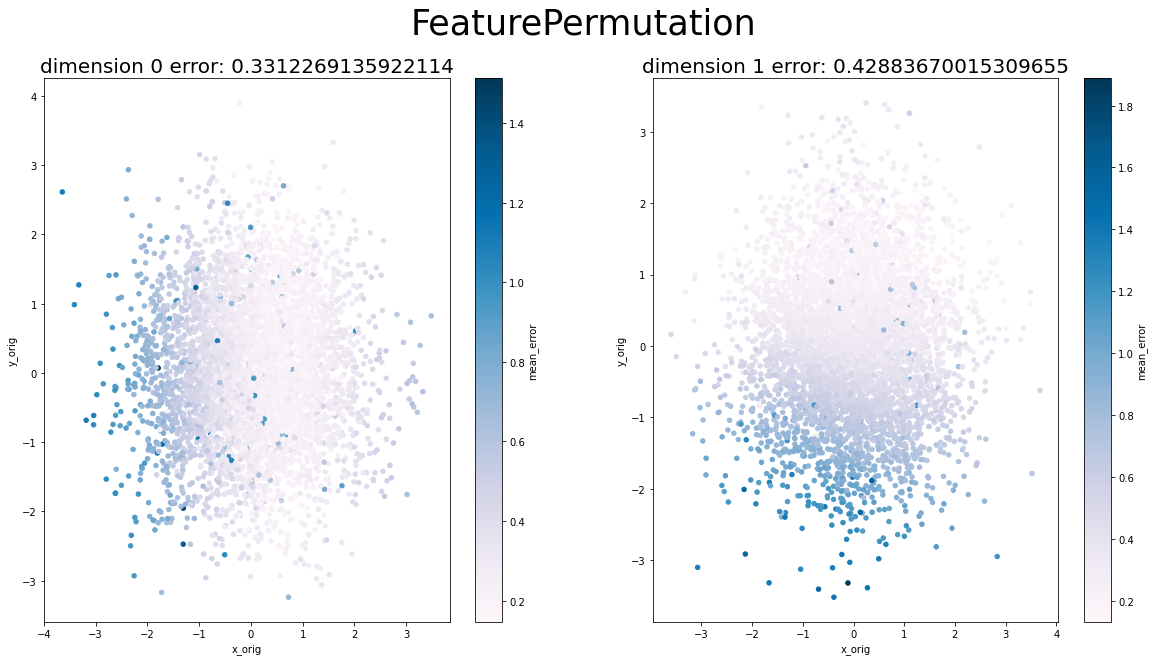

In [94]:
a, b = get_mean_error(experiment_id='p0.00', method='FeaturePermutation')

50


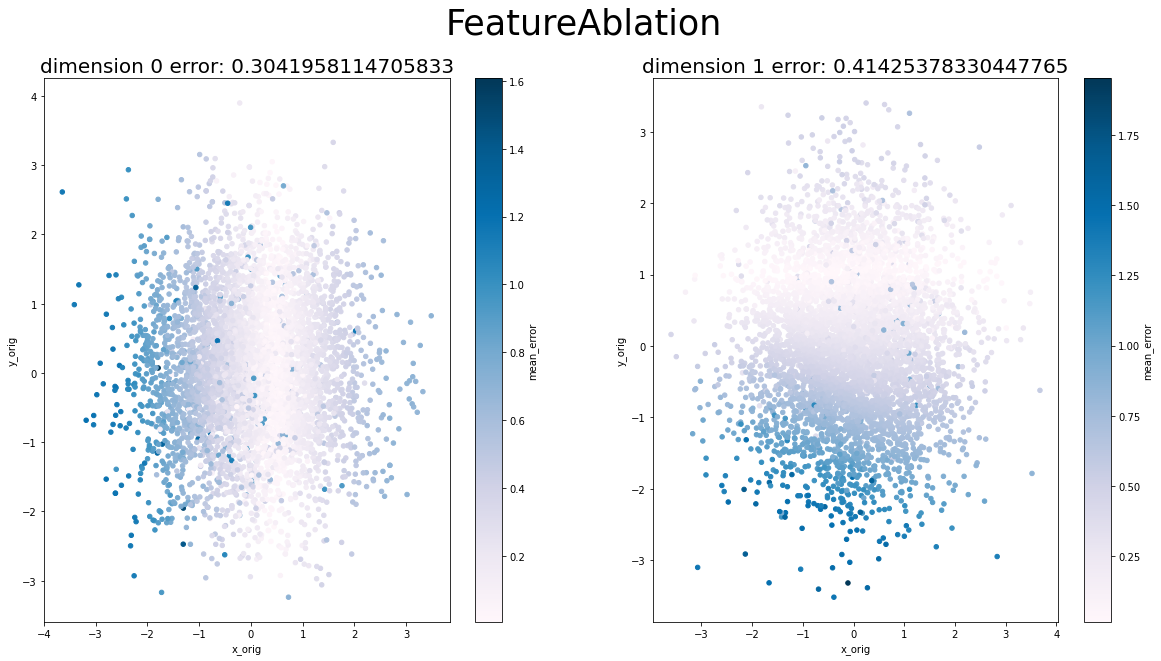

In [95]:
a, b = get_mean_error(experiment_id='p0.00', method='FeatureAblation')

50


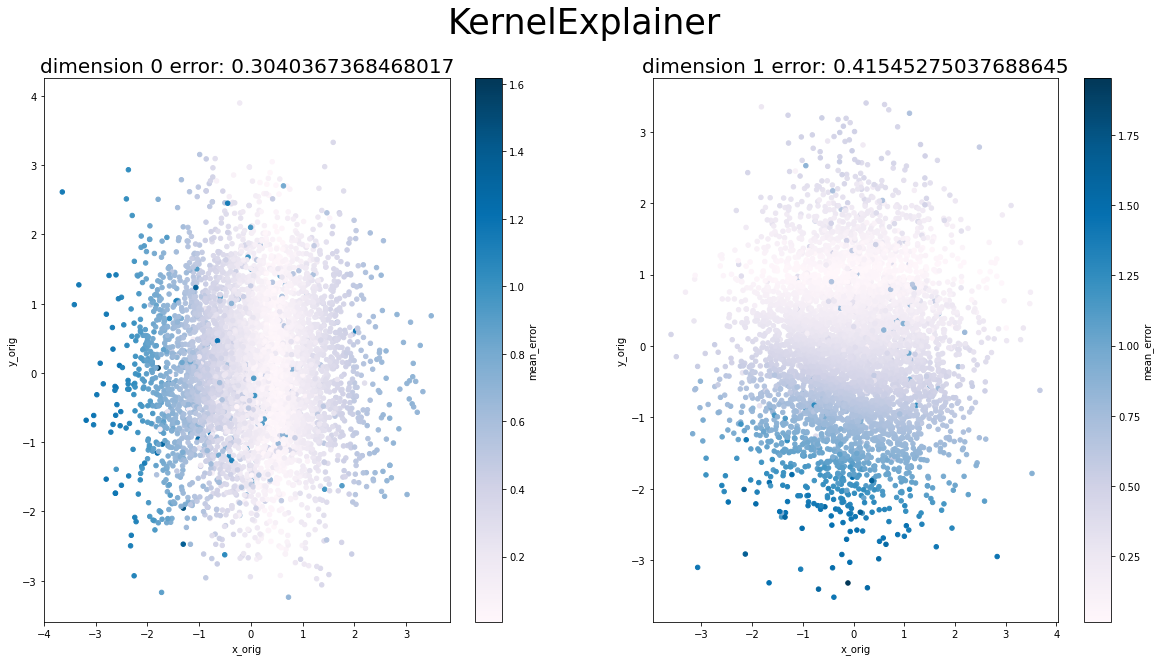

In [96]:
a, b = get_mean_error(experiment_id='p0.00', method='KernelExplainer')

50


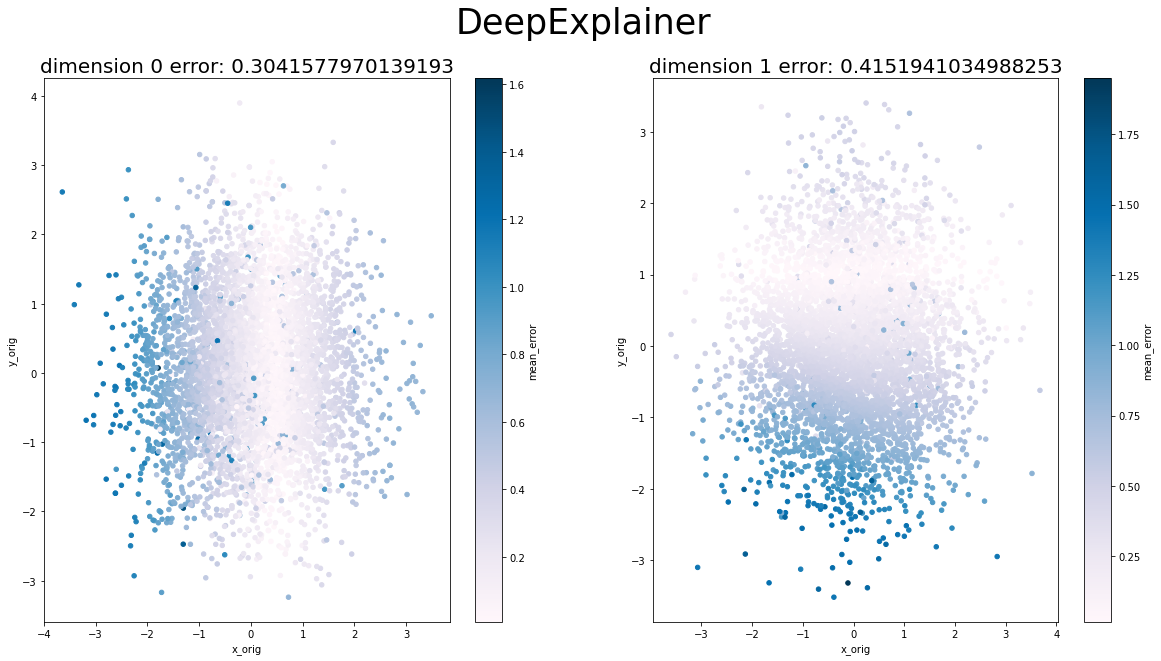

In [97]:
a, b = get_mean_error(experiment_id='p0.00', method='DeepExplainer')

50


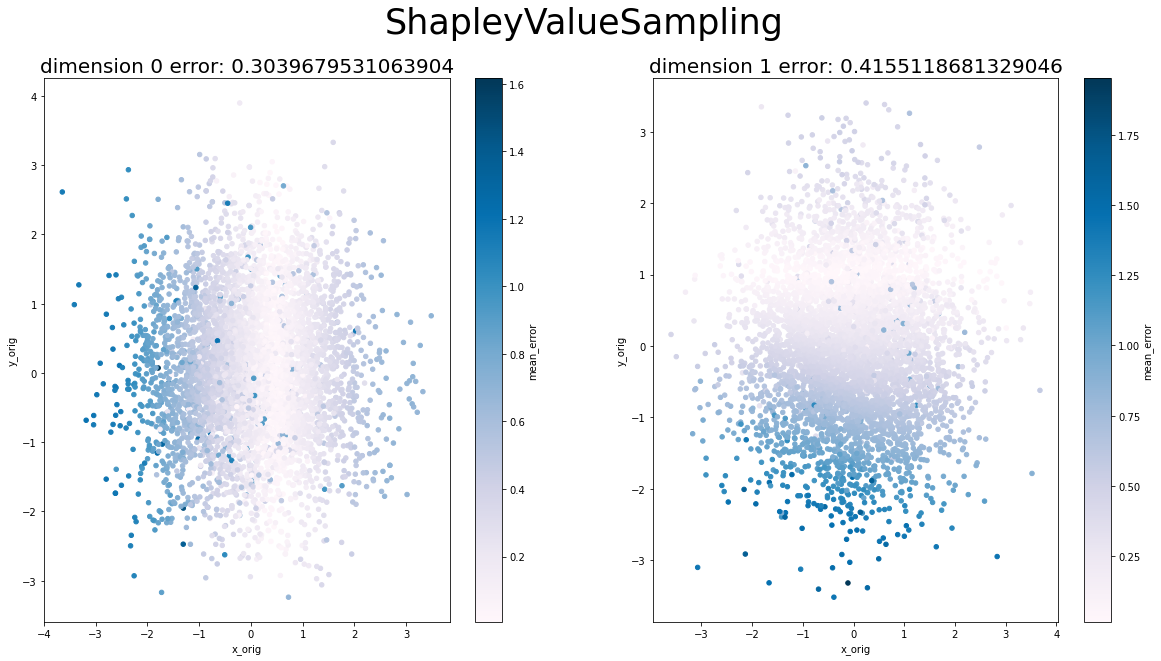

In [98]:
a, b = get_mean_error(experiment_id='p0.00', method='ShapleyValueSampling')

50


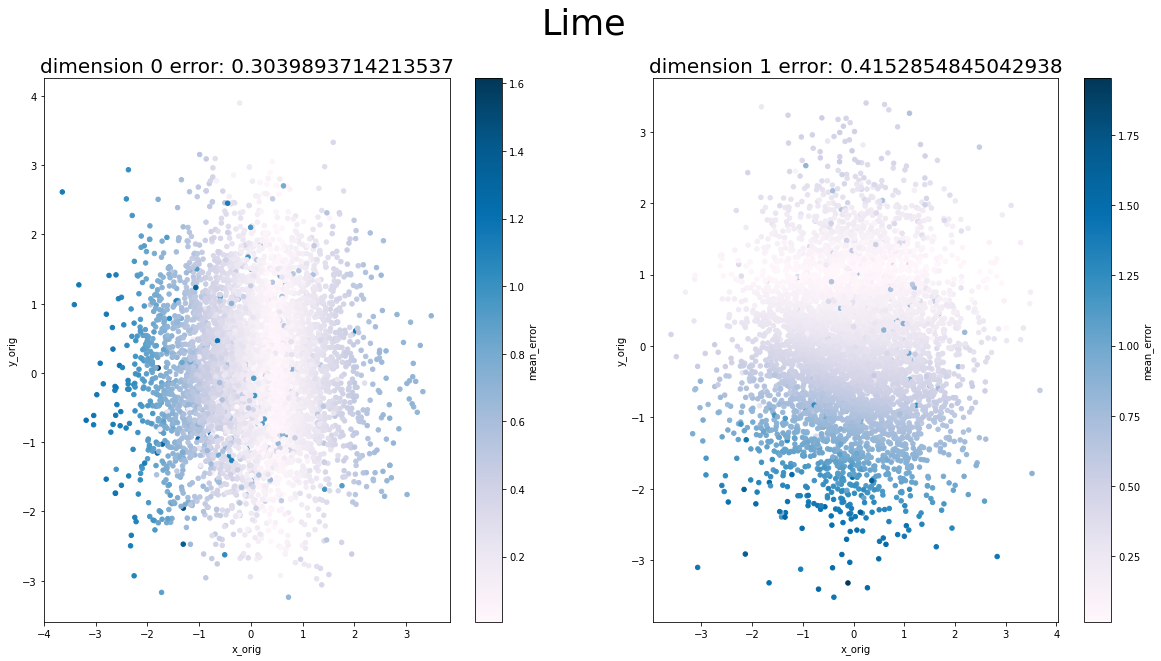

In [99]:
a, b = get_mean_error(experiment_id='p0.00', method='Lime')

50


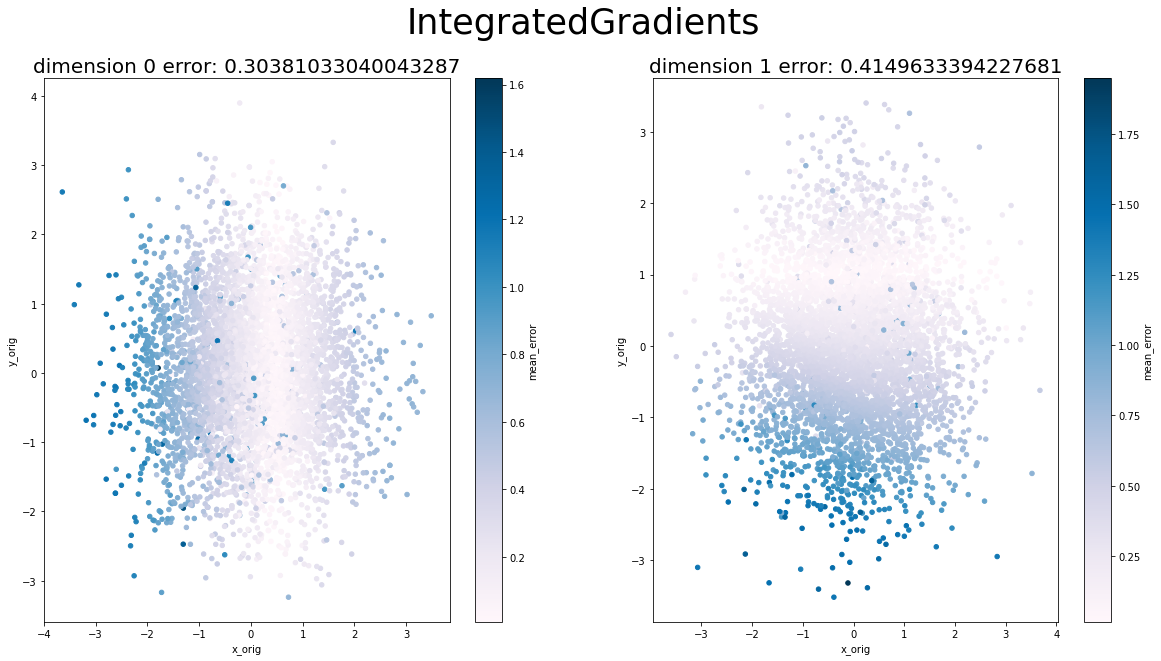

In [100]:
a, b = get_mean_error(experiment_id='p0.00', method='IntegratedGradients')

50


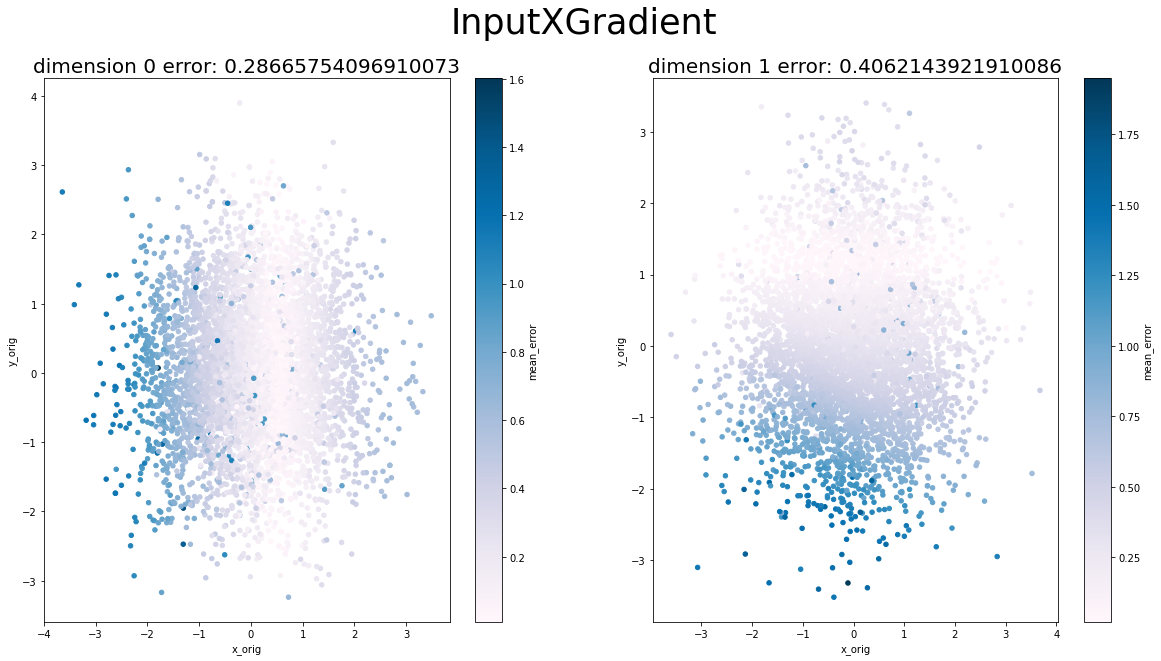

In [102]:
a, b = get_mean_error(experiment_id='p0.00', method='InputXGradient')

## p = -0.75

44


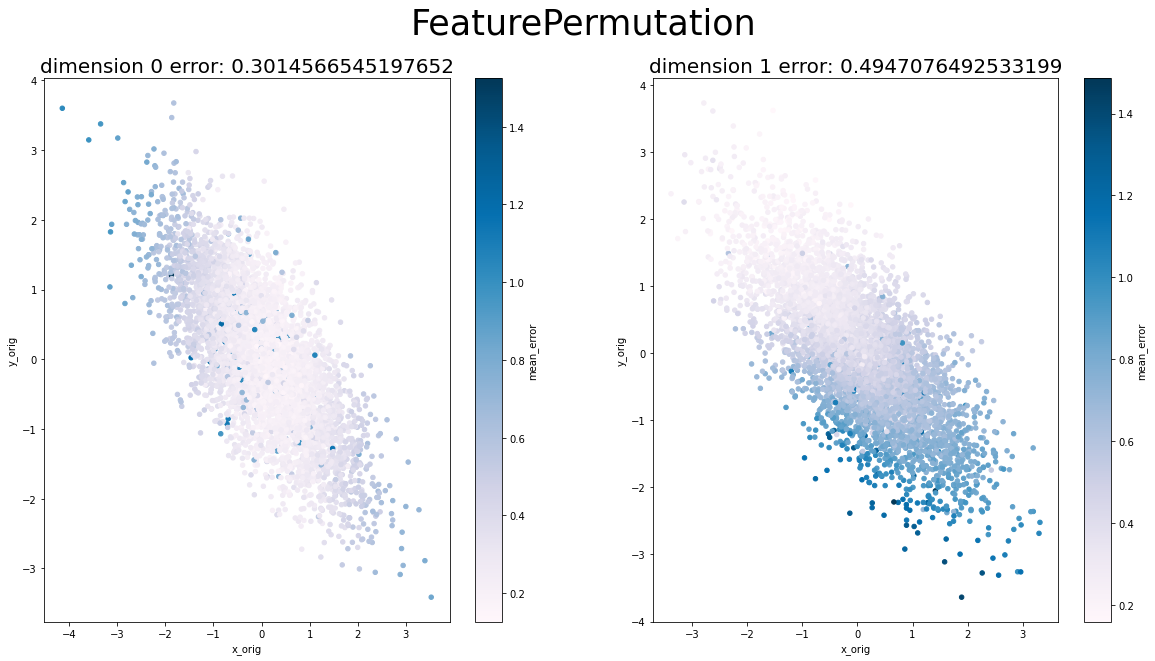

In [104]:
a, b = get_mean_error(experiment_id='p-0.75', method='FeaturePermutation')

44


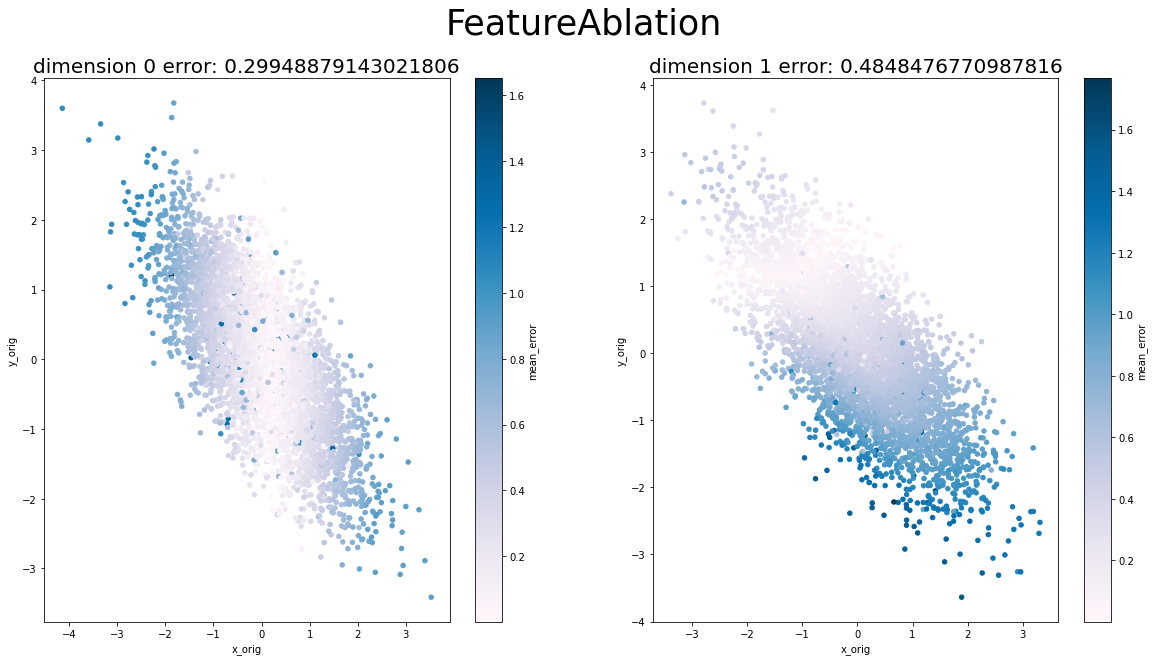

In [105]:
a, b = get_mean_error(experiment_id='p-0.75', method='FeatureAblation')

44


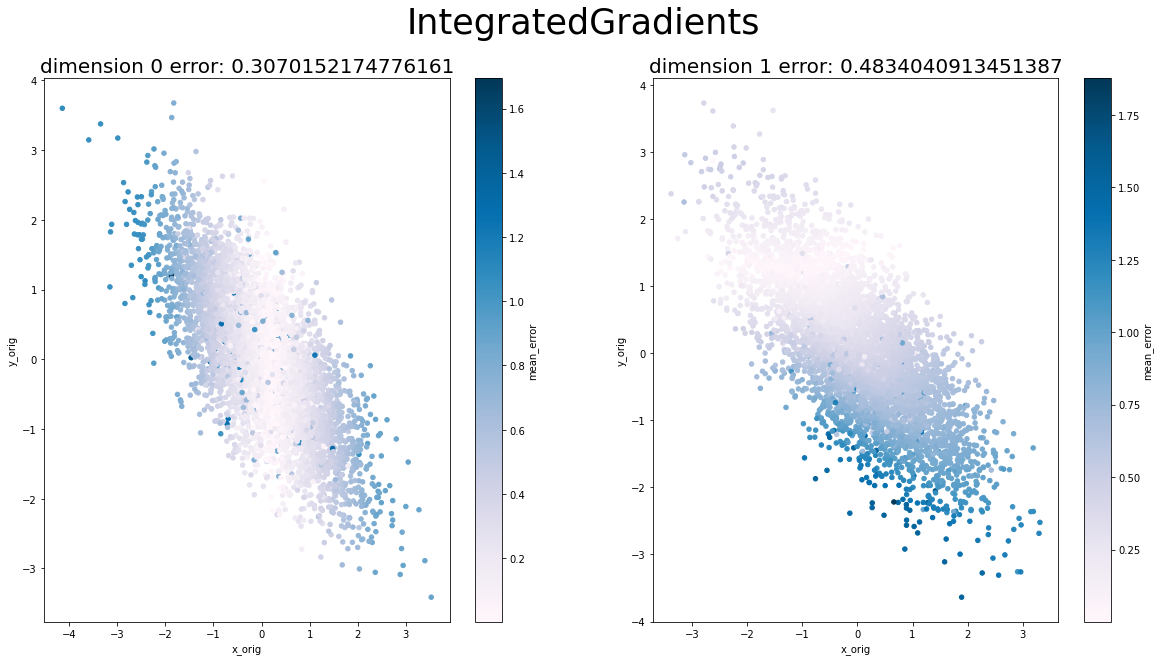

In [106]:
a, b = get_mean_error(experiment_id='p-0.75', method='IntegratedGradients')

44


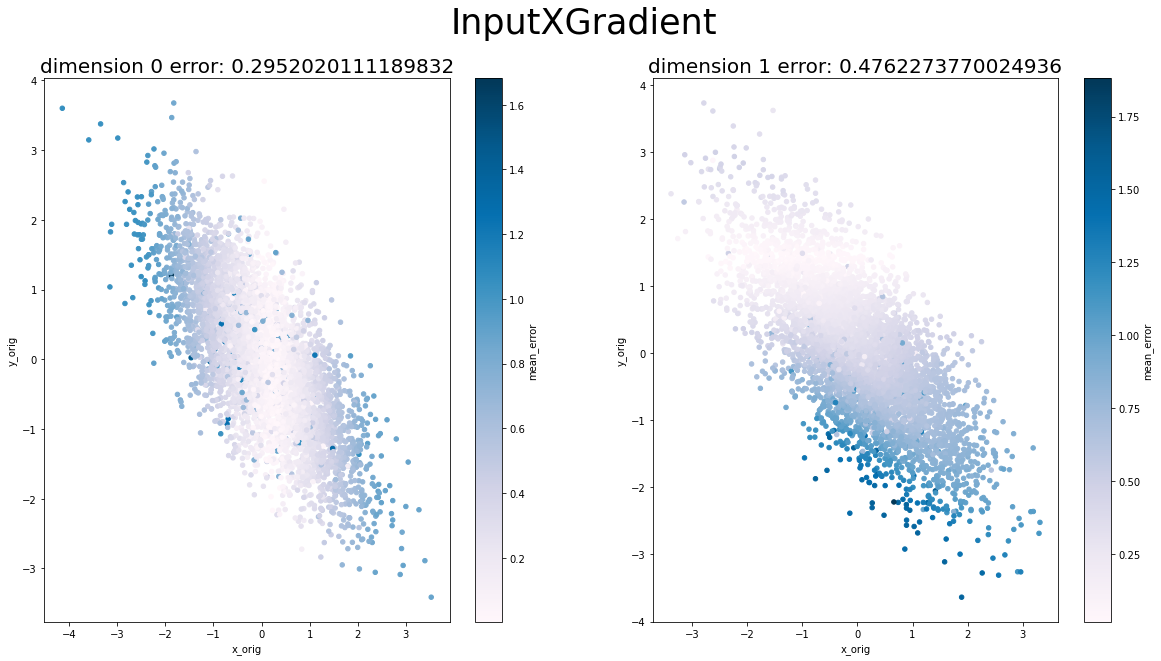

In [111]:
a, b = get_mean_error(experiment_id='p-0.75', method='InputXGradient')

44


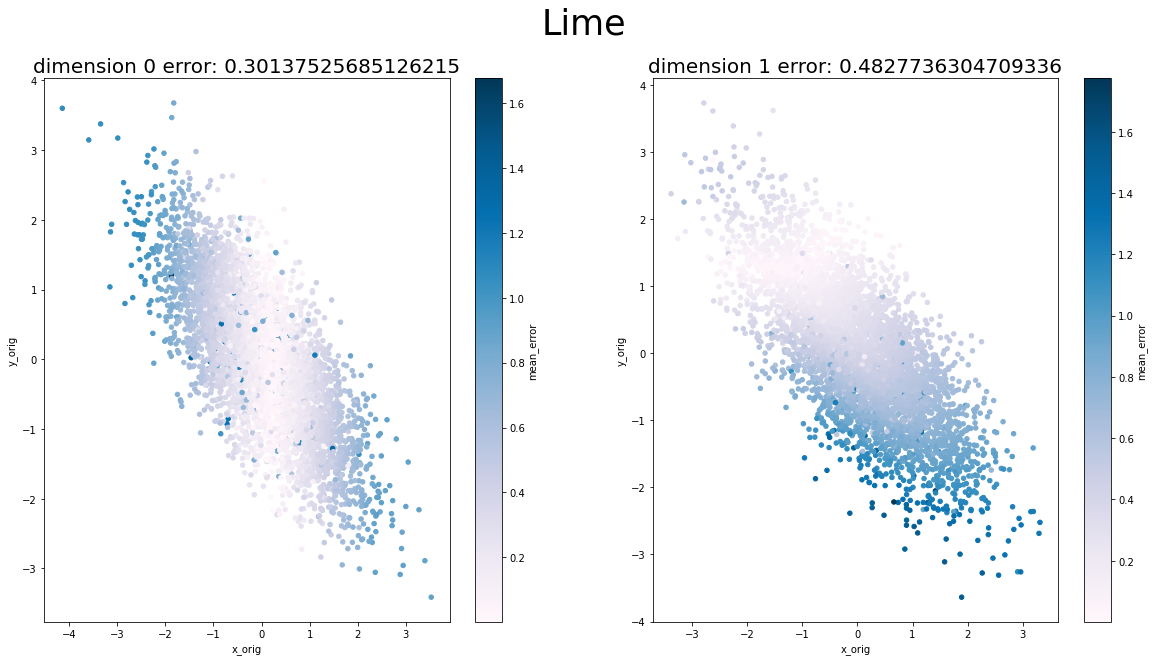

In [107]:
a, b = get_mean_error(experiment_id='p-0.75', method='Lime')

44


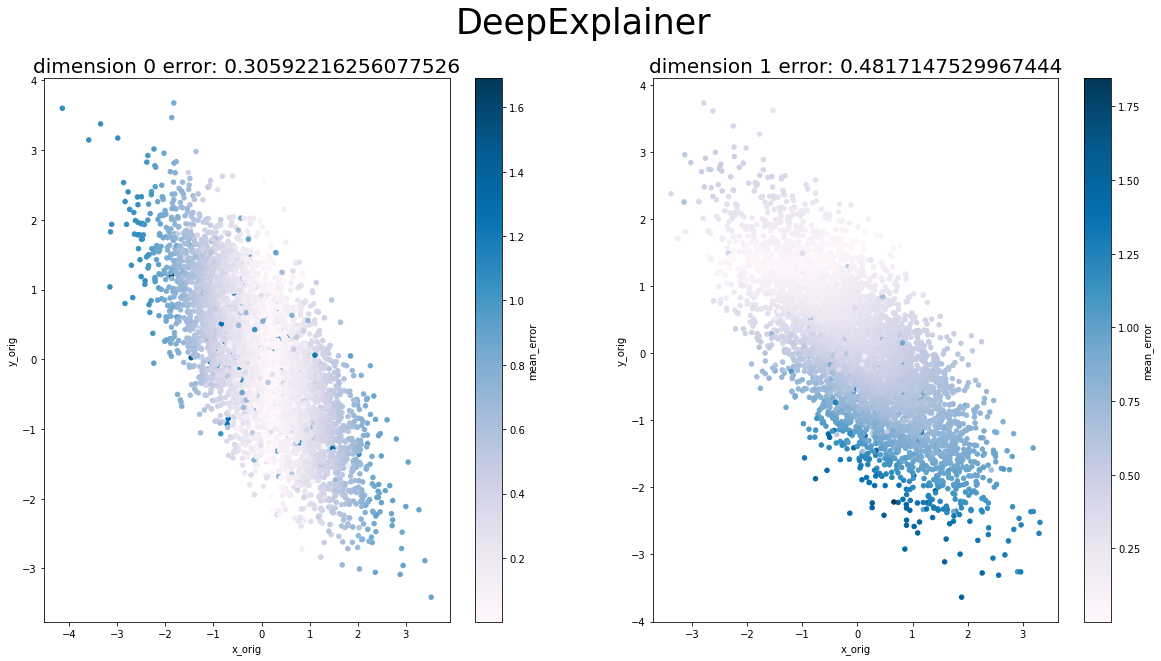

In [108]:
a, b = get_mean_error(experiment_id='p-0.75', method='DeepExplainer')

44


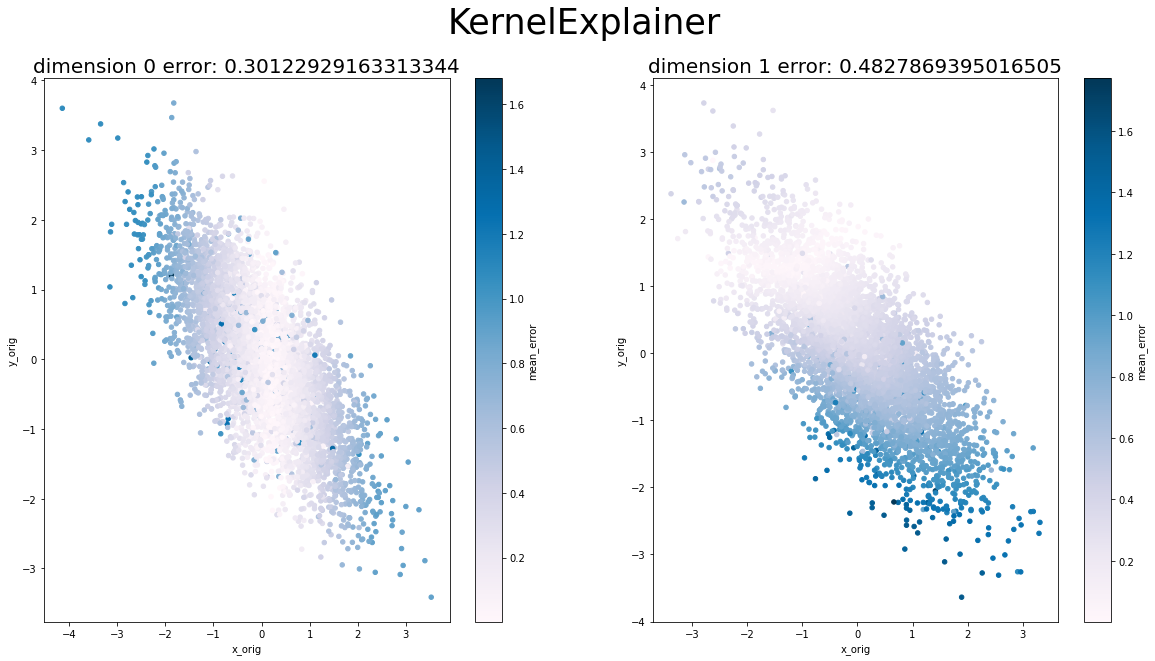

In [109]:
a, b = get_mean_error(experiment_id='p-0.75', method='KernelExplainer')

44


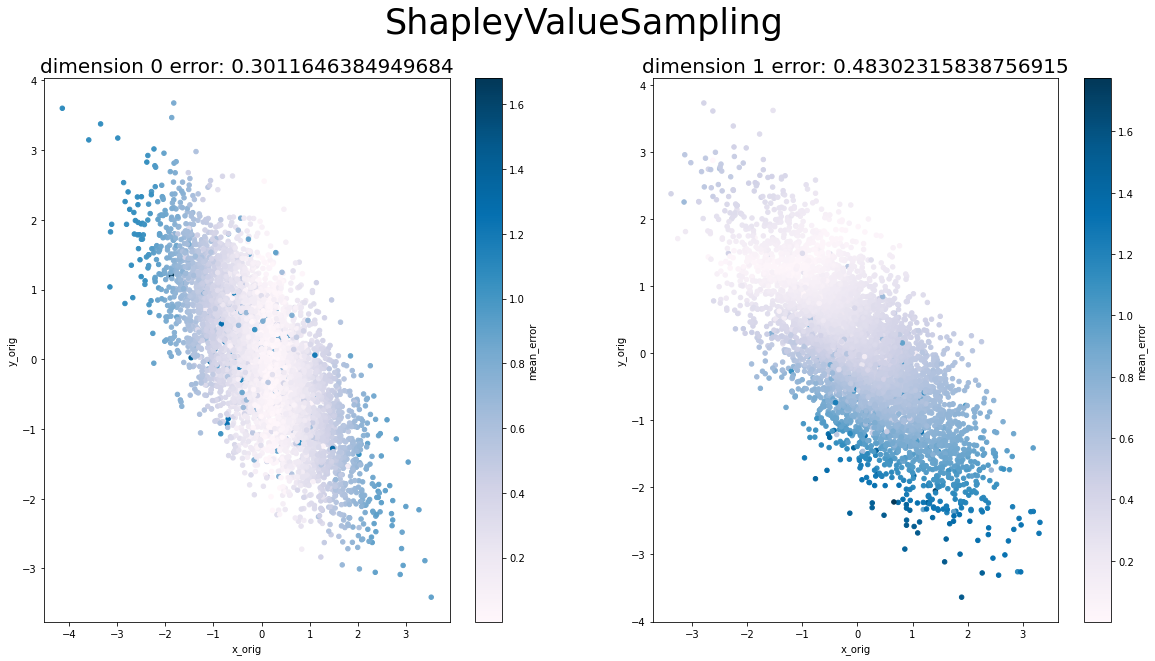

In [110]:
a, b = get_mean_error(experiment_id='p-0.75', method='ShapleyValueSampling')

44


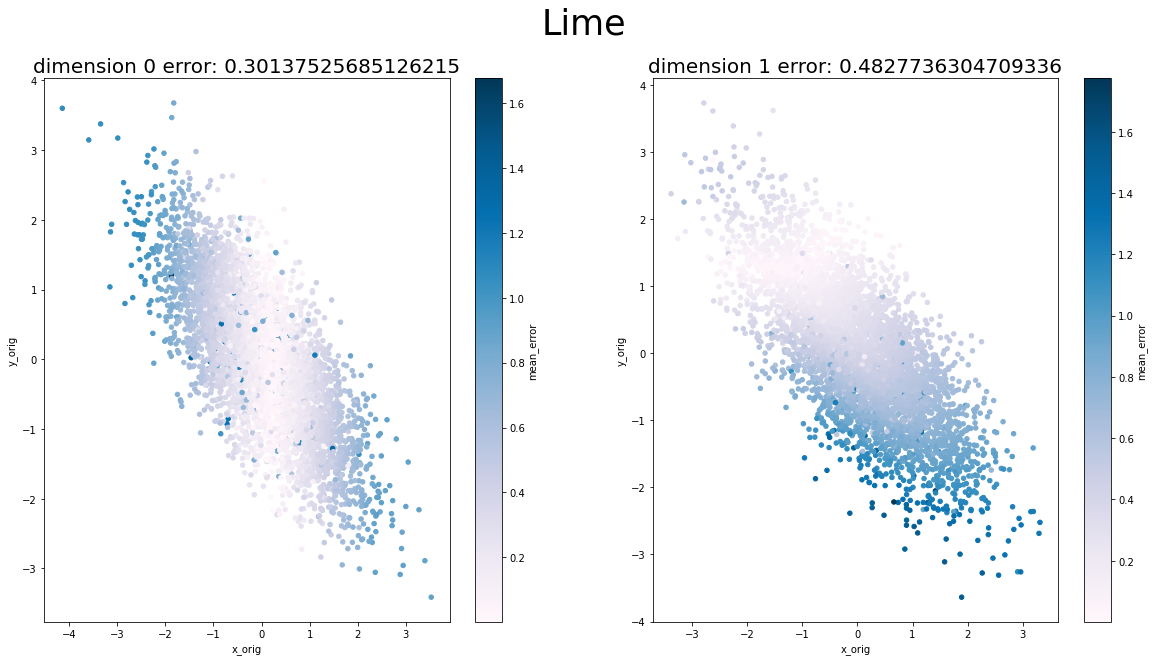

In [112]:
a, b = get_mean_error(experiment_id='p-0.75', method='Lime')